In [112]:
import pandas as pd
import gzip
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from catboost import CatBoostRegressor
import lightgbm as lgb



### With the cleaned and cleaved feature set, I now wish to explore correlations and feature importance to the price feature. Before that though, I need to ensure that all features are defined correctly in terms of datatype and categorical variables are label encoded (or create dummy variables) and corrctly defined as labeled

In [90]:
listings = pd.read_csv("listings_cleaned_cleaved.csv")

In [91]:
listings.columns

Index(['host_since', 'host_location', 'host_is_superhost',
       'host_neighbourhood', 'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates',
       'bathrooms_text', 'beds', 'amenities', 'price', 'minimum_nights',
       'maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
       'has_availability', 'availability_30', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'first_review',
       'review_scores_rating', 'instant_bookable', 'reviews_per_month',
       'overall_rating_is_imputed'],
      dtype='object')

host_location, host_neighbourhood, neighbourhood_cleansed, neighbourhood_group_cleansed and property_type should all be label encoded and defined as nominal categorical variables (no ordering) 

In [92]:
#listings['host_location'] = listings['host_location'].astype('category').cat.codes
listings['host_location'] = listings['host_location'].astype('category')

#listings['host_neighbourhood'] = listings['host_neighbourhood'].astype('category').cat.codes
listings['host_neighbourhood'] = listings['host_neighbourhood'].astype('category')

#listings['neighbourhood_cleansed'] = listings['neighbourhood_cleansed'].astype('category').cat.codes
listings['neighbourhood_cleansed'] = listings['neighbourhood_cleansed'].astype('category')

#listings['neighbourhood_group_cleansed'] = listings['neighbourhood_group_cleansed'].astype('category').cat.codes
listings['neighbourhood_group_cleansed'] = listings['neighbourhood_group_cleansed'].astype('category')

#listings['property_type'] = listings['property_type'].astype('category').cat.codes
listings['property_type'] = listings['property_type'].astype('category')


Bathrooms_text is a bit tricky since it is defined as text strings, but there is a clear order which is likely to impact price. Therefore I manually define an order for the different categories and then label encode it. 

In [93]:
listings["bathrooms_text"].unique()

array(['1 shared bath', '1 bath', '1 private bath', '2 baths',
       '2.5 baths', '1.5 baths', '4 shared baths', '2 shared baths',
       '1.5 shared baths', 'Shared half-bath', 'Half-bath', '3 baths',
       '3.5 baths', '3 shared baths', '4 baths', '0 shared baths',
       '6.5 baths', '2.5 shared baths', '0 baths', '4.5 baths', '5 baths',
       '6 baths', '7 baths', '15.5 baths', 'Private half-bath',
       '5.5 shared baths', '8 baths', '6 shared baths', '5.5 baths',
       '4.5 shared baths', '8.5 baths', '3.5 shared baths'], dtype=object)

In [94]:
order = ['0 shared baths','0 baths', 'Shared half-bath','Half-bath', 'Private half-bath',
 '1 shared bath', '1 bath', '1 private bath', '1.5 shared baths', '1.5 baths', '2 shared baths',
 '2 baths', '2.5 shared baths', '2.5 baths', '3 shared baths', '3 baths', '3.5 shared baths',
 '3.5 baths', '4 shared baths', '4 baths','4.5 shared baths', '4.5 baths', '5 baths', 
 '5.5 shared baths', '5.5 baths', '6 shared baths','6 baths', '6.5 baths', '7 baths', '8 baths',
 '8.5 baths', '15.5 baths']

listings['bathrooms'] = pd.Categorical(listings['bathrooms_text'], 
categories=order, ordered=True)


In [95]:
listings['bathrooms'].unique()


['1 shared bath', '1 bath', '1 private bath', '2 baths', '2.5 baths', ..., '6 shared baths', '5.5 baths', '4.5 shared baths', '8.5 baths', '3.5 shared baths']
Length: 32
Categories (32, object): ['0 shared baths' < '0 baths' < 'Shared half-bath' < 'Half-bath' ... '7 baths' < '8 baths' < '8.5 baths' < '15.5 baths']

In [96]:
listings["room_type"].unique()

array(['Private room', 'Entire home/apt', 'Shared room', 'Hotel room'],
      dtype=object)

Room_type can also be defined as an ordinal categorical variable

In [1]:
order = ['Shared room', 'Private room', 'Hotel room', 'Entire home/apt']

listings['room_type'] = pd.Categorical(listings['room_type'], 
categories=order, ordered=True)


NameError: name 'pd' is not defined

In [98]:
listings['room_type'].unique()

['Private room', 'Entire home/apt', 'Shared room', 'Hotel room']
Categories (4, object): ['Shared room' < 'Private room' < 'Hotel room' < 'Entire home/apt']

#### Now convert date variables to the datetime datatype

In [99]:
listings['first_review'] = pd.to_datetime(listings['first_review'])
listings['host_since'] = pd.to_datetime(listings['host_since'])


#### Last but not least, we need to fix the price column so it is an actual float and not just string with dollar sign at the beginning.

In [100]:
listings['price'] = listings['price'].str.replace('$', '').str.replace(',', '').astype(float)

#### We also want to create a column which tells how many amenities a listing has, more amenities should increase price.

In [101]:
listings['amenities_count'] = listings['amenities'].str.strip('[]').str.split(',').apply(len)


#### Now create correlations matrix

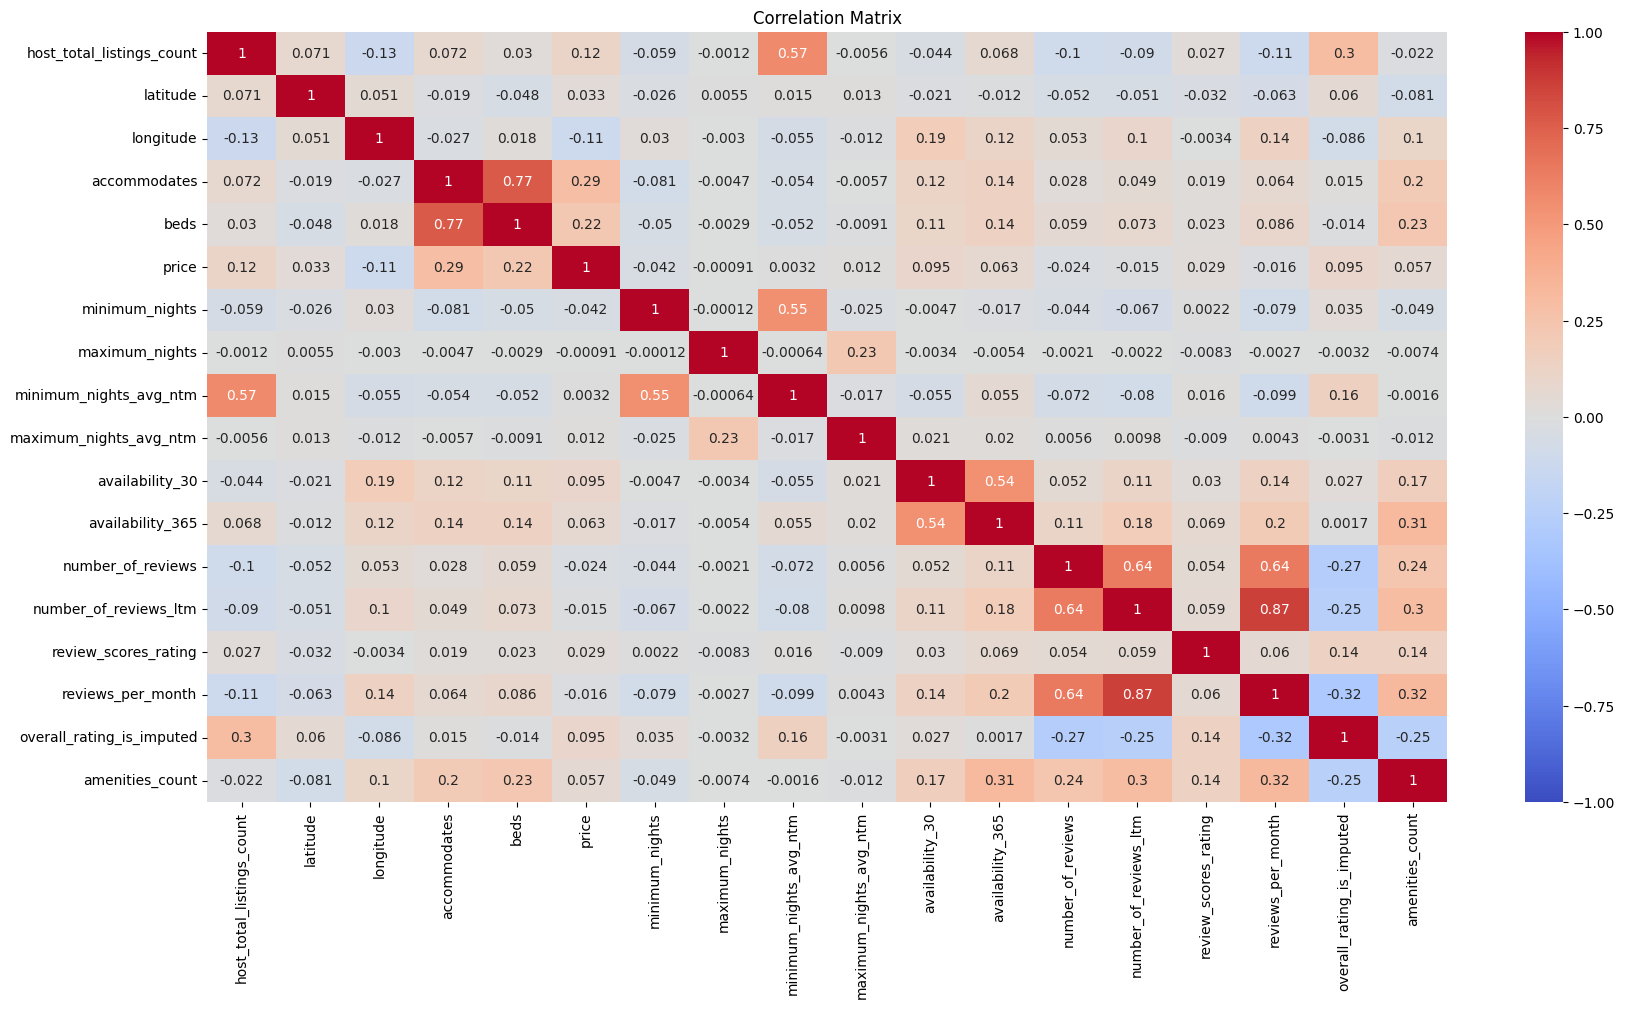

In [102]:
numeric_listings = listings.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numeric_listings.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()


#### Now we want to determine feature importance for predicting the price.

We see below that many of the binary columns have "object" as datatype. We want to convert this to categorical. We also remove host_verifications temporarily because it is an annoying feature. We remove bathrooms_text because it is replacable by bathrooms. Also temporarily remove amenities. We drop has_availiability because it is well covered by availability_30 and availability_365. I also fix the datetime columns so that they represent days backwards from most recent date in the set (October 1st 2023).

In [109]:
print(listings.dtypes)


host_since                         int64
host_location                   category
host_is_superhost               category
host_neighbourhood              category
host_total_listings_count        float64
host_has_profile_pic            category
host_identity_verified          category
neighbourhood_cleansed          category
neighbourhood_group_cleansed    category
latitude                         float64
longitude                        float64
property_type                   category
room_type                       category
accommodates                       int64
beds                             float64
price                            float64
minimum_nights                     int64
maximum_nights                     int64
minimum_nights_avg_ntm           float64
maximum_nights_avg_ntm           float64
availability_30                    int64
availability_365                   int64
number_of_reviews                  int64
number_of_reviews_ltm              int64
first_review    

In [103]:
listings['host_is_superhost'] = listings['host_is_superhost'].astype('category')
listings['host_has_profile_pic'] = listings['host_has_profile_pic'].astype('category')
listings['instant_bookable'] = listings['instant_bookable'].astype('category')
listings['host_identity_verified'] = listings['host_identity_verified'].astype('category')


listings.drop('amenities', axis=1, inplace=True)
listings.drop('bathrooms_text', axis=1, inplace=True)
listings.drop('has_availability', axis=1, inplace=True)
listings.drop('host_verifications', axis=1, inplace=True)

In [105]:
reference_date = pd.to_datetime('2023-10-01')

listings['first_review'] = (reference_date - listings['first_review']).dt.days
listings['host_since'] = (reference_date - listings['host_since']).dt.days

In [106]:
X = listings.drop(columns='price')  # drop the target column
y = listings['price']

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Using catboost

In [114]:
model = CatBoostRegressor(iterations=500, depth=10, verbose=200, cat_features=["host_location", 
        "host_is_superhost", "host_neighbourhood", "host_has_profile_pic", "host_identity_verified", 
        "neighbourhood_cleansed", "neighbourhood_group_cleansed", "property_type", "room_type", "instant_bookable",
        "bathrooms"])
model.fit(X_train, y_train)

feature_importances = model.get_feature_importance()


Learning rate set to 0.123289
0:	learn: 477.8385446	total: 392ms	remaining: 3m 15s
200:	learn: 242.0909858	total: 30.7s	remaining: 45.7s
400:	learn: 196.3479296	total: 1m 1s	remaining: 15.1s
499:	learn: 181.3791472	total: 1m 16s	remaining: 0us


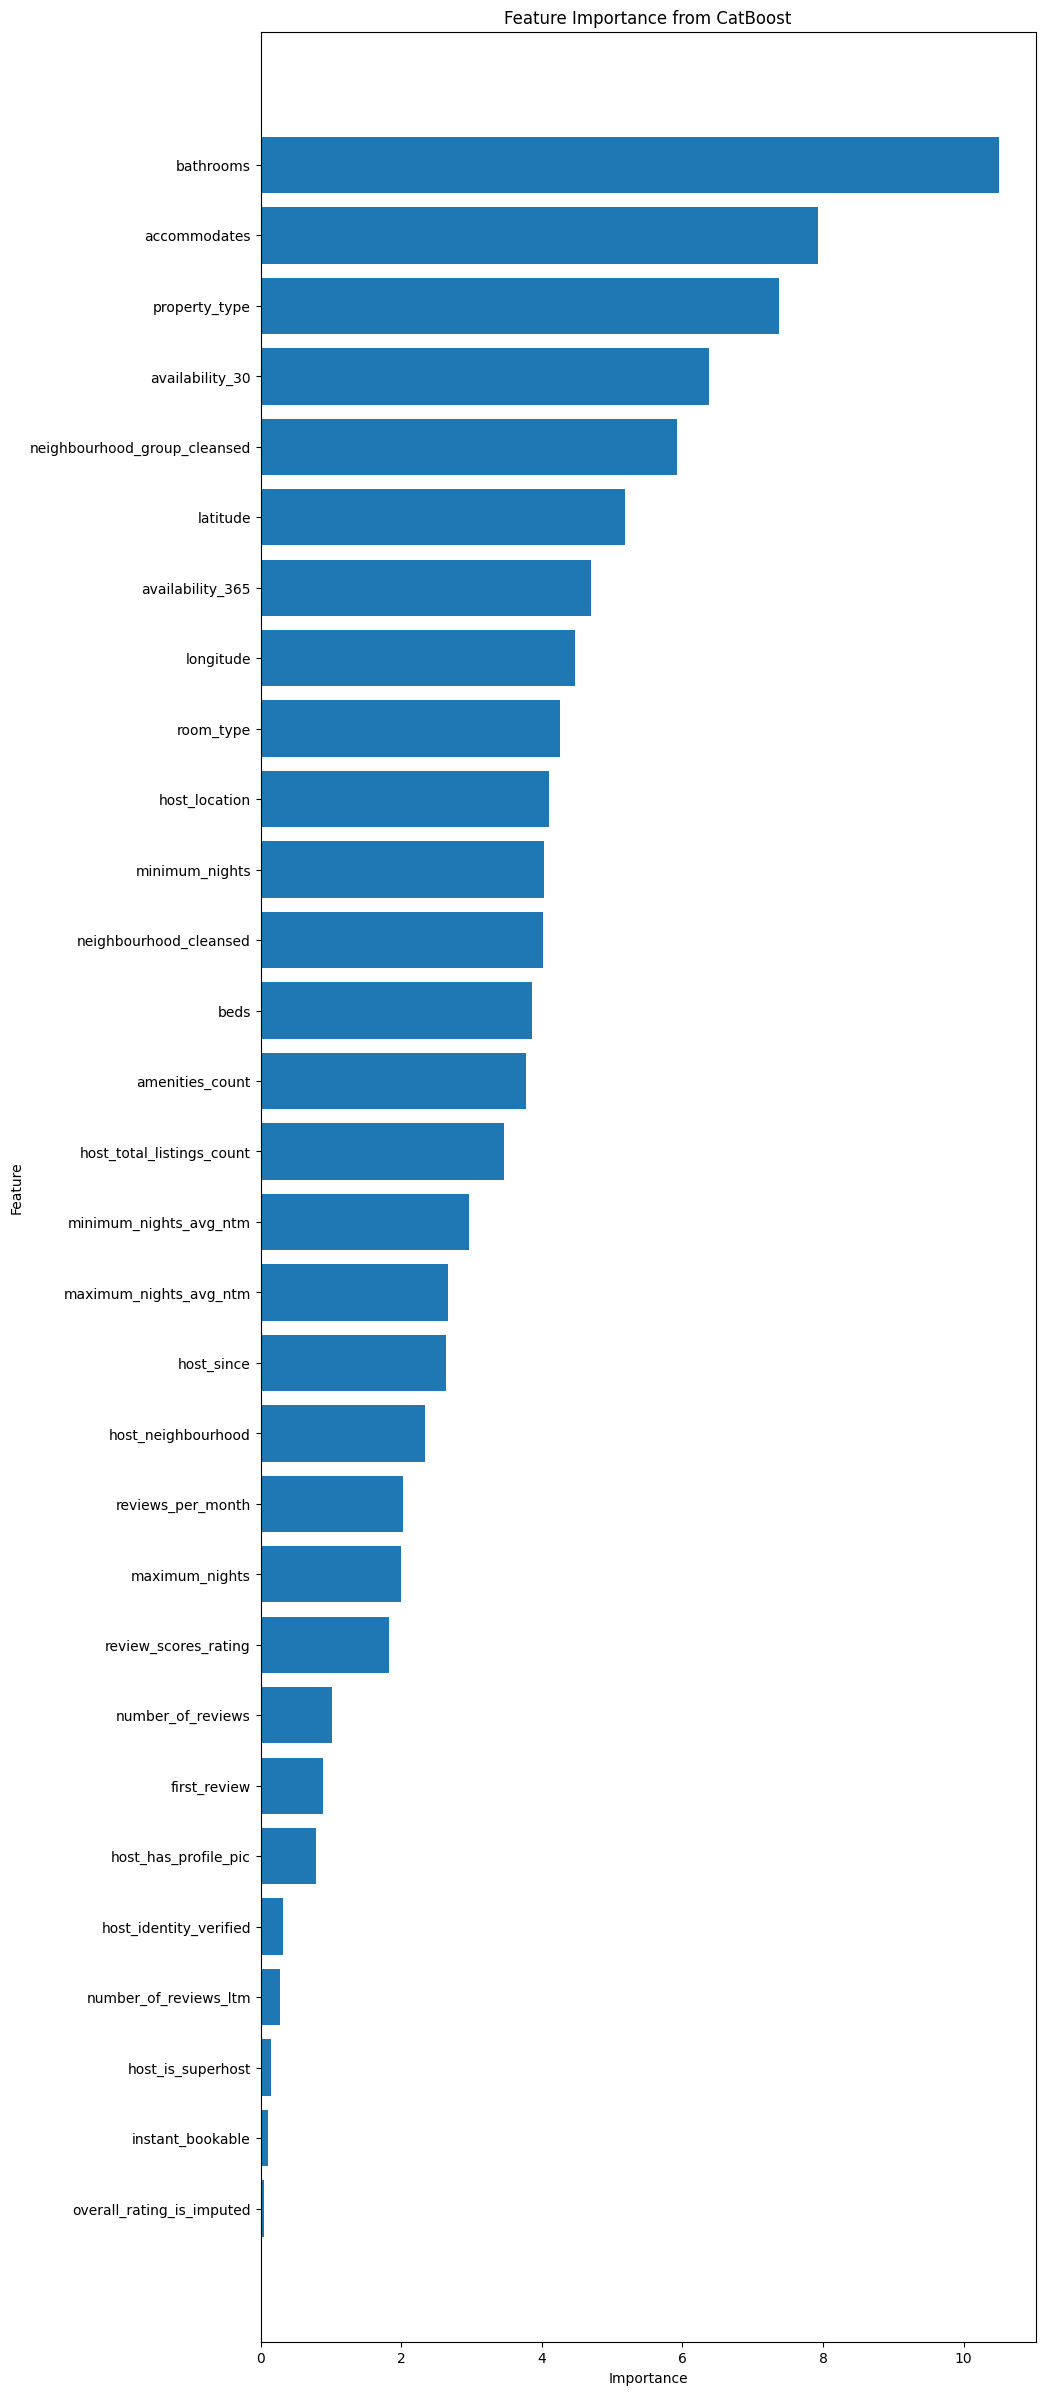

In [116]:
# Sort feature importances in descending order and get the indices
sorted_indices = feature_importances.argsort()[::-1]

# Create a horizontal bar plot
plt.figure(figsize=(10, len(X_train.columns)))
plt.barh(X_train.columns[sorted_indices], feature_importances[sorted_indices])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from CatBoost')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

### Using LightGBM

In [118]:
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=["host_location", 
        "host_is_superhost", "host_neighbourhood", "host_has_profile_pic", "host_identity_verified", 
        "neighbourhood_cleansed", "neighbourhood_group_cleansed", "property_type", "room_type", "instant_bookable",
        "bathrooms"])

params = {
    'objective': 'regression',
    'metric': 'l2',
    'verbosity': -1,
}

model = lgb.train(params, train_data, num_boost_round=100)

feature_importances = model.feature_importance()


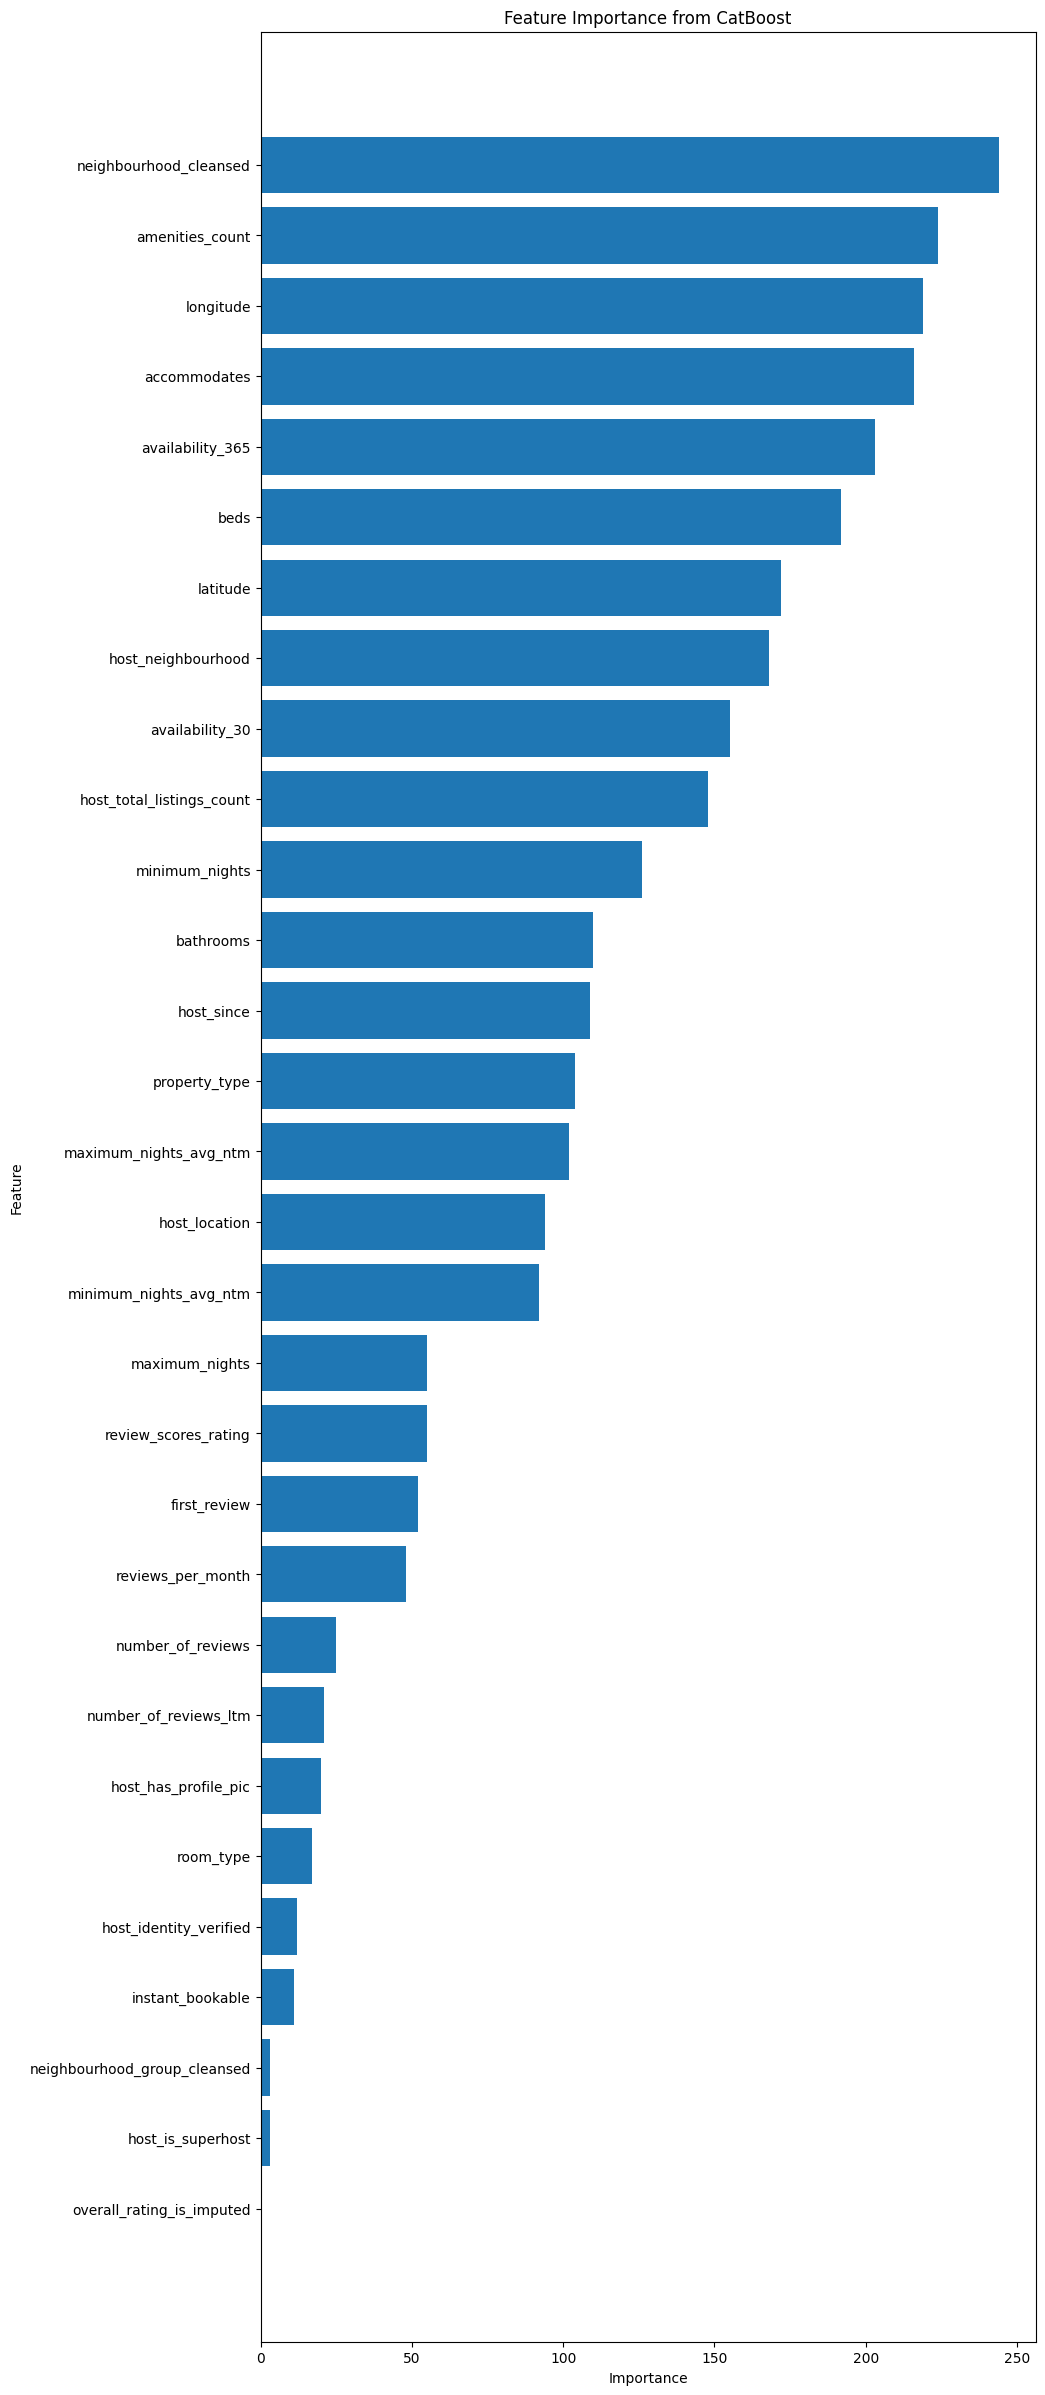

In [120]:
# Sort feature importances in descending order and get the indices
sorted_indices = feature_importances.argsort()[::-1]

# Create a horizontal bar plot
plt.figure(figsize=(10, len(X_train.columns)))
plt.barh(X_train.columns[sorted_indices], feature_importances[sorted_indices])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from LightGBM')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

This correlations matrix does not include the ordinal categorical variables, which is a shame. To counteract this, i will label encode these variables in such a manner that the lowest value is worst and the highest value is best

In [121]:
listings['room_type_encoded'] = listings["room_type"].cat.codes
listings['bathrooms_encoded'] = listings["bathrooms"].cat.codes

listings["bathrooms_encoded"]

0        5
1        6
2        6
3        6
4        6
        ..
37838    5
37839    6
37840    6
37841    6
37842    6
Name: bathrooms_encoded, Length: 37843, dtype: int8

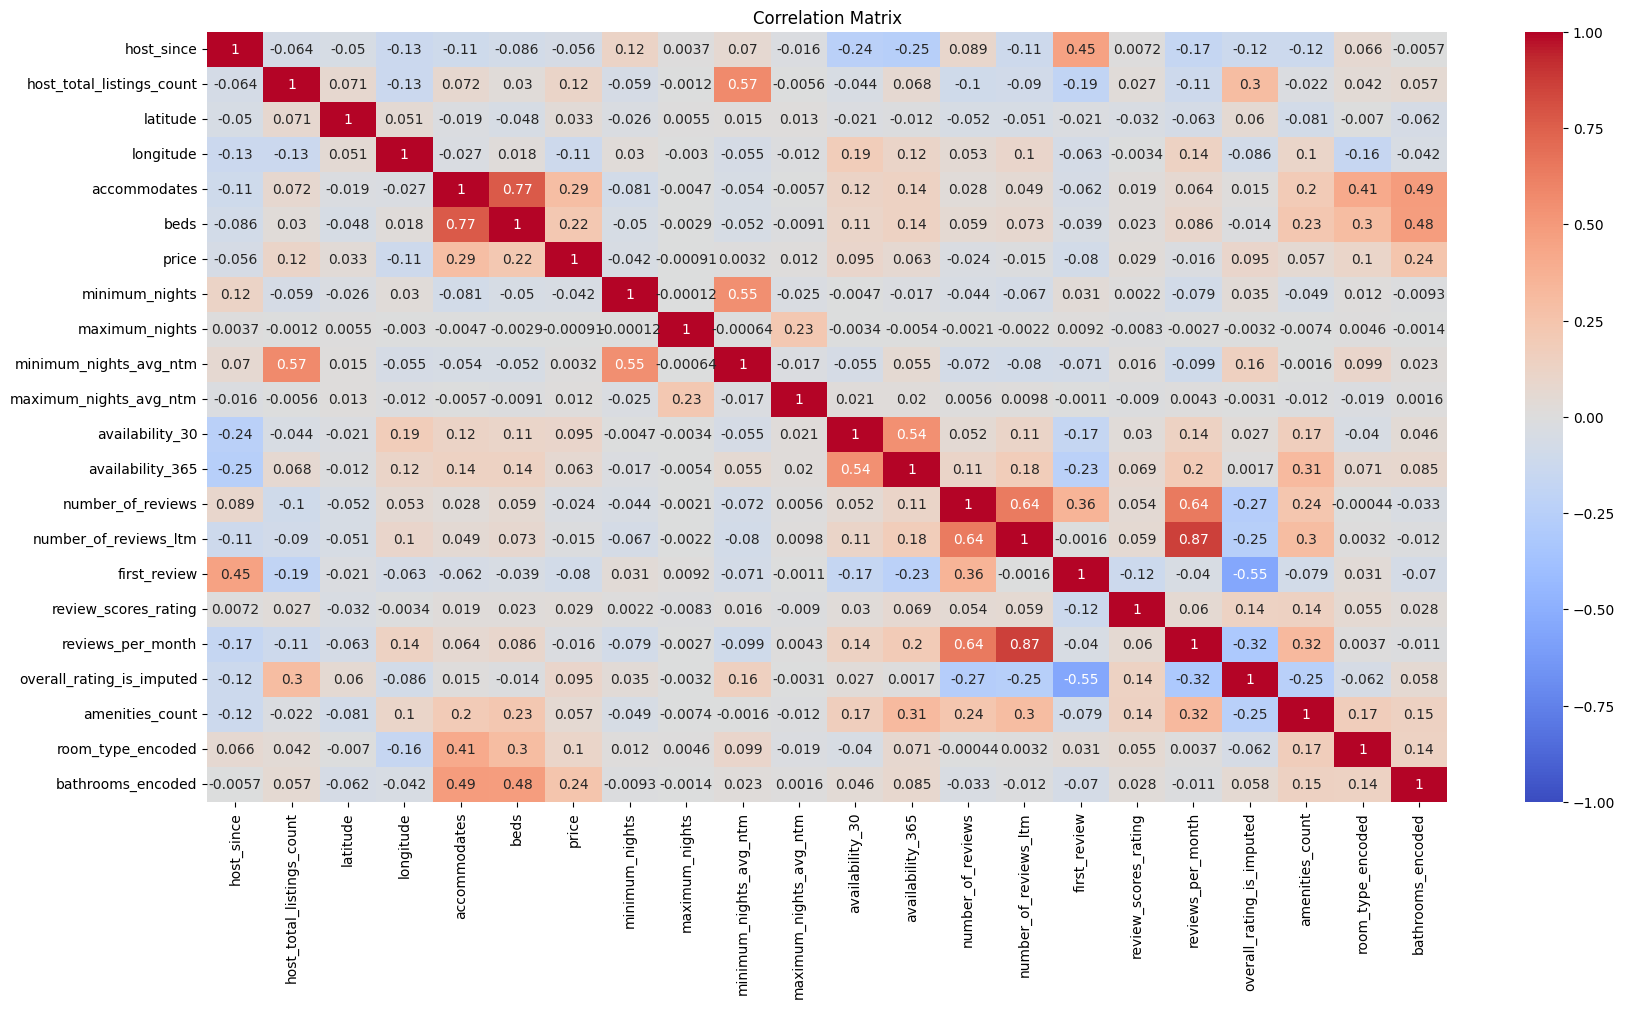

In [122]:
numeric_listings = listings.select_dtypes(include=['float64', 'int64', 'int8'])

correlation_matrix = numeric_listings.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()
